# Course Project: Swap Pricing and Counterparty Risk Modeling

Jingting Xu, Bohui Xi, Qilin Lu, Yi Hu, Haozheng Zhu

---
Summary: This is a course project for MATH-GA-2757 Regulation and Regulatory Risk Models. The primary target of the project is to help us understand concept of credit risk management and credit risk model application in real case. We assume the underlying as a swap contract and calculate the regulatory capital required by Basel 3.  

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import random

## Market Setting

The following part is the market setting. Consider an economy where the instantaneous OIS forward rate term structure is observed at time 0 to be flat at 100bps, which defines $OIS(0,T)$ = 2%. The time 0 spread between the LIBOR forward curve and the OIS forward curve is flat at 50 bps, such that $L(0,T)$ = 2.5%. Assuming parameter for two-factor Gaussian model are $\sigma_r = 2\%$, $c = 35\%$, $\kappa_1 = 2\%$, $\kappa_2 = 10\%$, $\rho_\infty = 40\%$. Correlation between parties and interest rate are as follow,<br>
$corr(d\lambda_B(t),df_{OIS}(t,\infty)) = 10\%$,<br>
$corr(d\lambda_C(t),df_{OIS}(t,\infty)) = 10\%$,<br>
$corr(d\lambda_B(t),dr_{OIS}(t)) = 25\%$,<br>
$corr(d\lambda_C(t),dr_{OIS}(t)) = 25\%$,<br>
$corr(d\lambda_B(t), d\lambda_C(t)) = 75\%$

In [90]:
dt = 1/12
T = 10
sigma_r = 0.02
c = 0.35
kappa_1 = 0.02
kappa_2 = 0.1
corr = 0.4
OIS_0_T = 0.02
L_0_T = 0.025
corr_B_L = 0.1
corr_B_S = 0.25
corr_C_L = 0.1
corr_C_S = 0.25
corr_B_C = 0.75
notion = 150000000
thre_c = 0.2
thre_lambda = 0.0375

The following part is for credit curve setting. In two-factor Gaussian Model, we have one more Brownian motion. To emphasize the correlation structure of the 2-dimentional model, we need to adjust the parameters by following process. lambda_func is the defalut intensity simulation for both parties."__B__" represents the bank and "__C__" represents the counterparty. The return value of corr_variables and lambda_func are both for next step in buling two-factor Gaussian Model. 

## Credit Curve Setting 

In [91]:
from scipy.linalg import cholesky

def corr_variables(corr_B_L,corr_B_S,corr_C_L,corr_C_S,corr_B_C,corr,c):

    vega = np.sqrt(c ** (-2) - 1 - 2 * (corr/c - 1))
    corr_l2 = (corr/c - 1)/vega
    corr_B1 = corr_B_L
    corr_B2 = corr_B_S * np.sqrt(vega **2 +1 + 2 * corr_l2 * vega) - corr_B1 * vega
    corr_C1 = corr_C_L
    corr_C2 = corr_C_S * np.sqrt(vega **2 +1 + 2 * corr_l2 * vega) - corr_C1 * vega
    corr_BC = corr_B_C
    correlation = np.matrix([[1,corr_BC,corr_B1,corr_B2],[corr_BC,1,corr_C1,corr_C2],\
                             [corr_B1,corr_C1,1,corr_l2],[corr_B2,corr_C2,corr_l2,1]])
    L = cholesky(a = correlation, lower = True)
    X = np.random.standard_normal(size = (120,4))
    Z = L.dot(X.transpose()).transpose()
    return Z

# global corr_matrix
# corr_matrix = corr_variables(corr_B_L,corr_B_S,corr_C_L,corr_C_S,corr_B_C,corr,c)

def lambda_func(firm):    
    corr_matrix = corr_variables(corr_B_L,corr_B_S,corr_C_L,corr_C_S,corr_B_C,corr,c)
    random = corr_matrix    
    Lambda = np.zeros((121,20))
    if firm == 'B':
        Z = random[:,0]
        lambda_0 = 0.01
        sigma = 0.005
        kappa = 0.1
        Lambda[:,0] = lambda_0
    if firm == 'C':
        Z = random[:,1]
        lambda_0 = 0.03
        sigma = 0.01
        kappa = 0.1
        Lambda[:,0] = lambda_0

    X_t = np.zeros((121,1))
    Y_t = np.zeros((121,1))
    Y_t[0] = 0
    X_t[0] = 0
    dt = 1/12
    for n in range(120):
        t = (n+1)/12
        Y_t[n+1] = (sigma ** 2 / (2*kappa)) * (1-np.exp(-2*kappa* t))
        X_t[n+1] = X_t[n] + (Y_t[n] - kappa * X_t[n]) * dt + sigma * Z[n] * np.sqrt(dt)


    #calclate lambda(t,T)
    for n in range(120):
        t = (n+1)/12
        for i in range(20):
            T = (i+1)/2
            if T >= t:
                G = (1/kappa) * (1-np.exp(-kappa * (T-t)))
                Lambda[n+1,i] = max(lambda_0 + np.exp(-kappa * (T-t)) * (X_t[n+1] + Y_t[n+1] * G),0)
    
    
    return Lambda


While the correlation between short end and long end of forward curve is the key to simulate correct interest rate curve. The next step is the function for creating forward curve by considering all parameters and correlation. 

In [92]:
def OIS_rate(dt,T,sigma_r,c,kappa_1,kappa_2,corr,OIS_0_T):
    corr_matrix = corr_variables(corr_B_L,corr_B_S,corr_C_L,corr_C_S,corr_B_C,corr,c)
    Z = corr_matrix[:,2:4]
    vega = np.sqrt(c ** (-2) - 1 - 2 * (corr/c - 1))
    corr_x = (corr/c - 1)/vega
    sigma_1 = c*sigma_r
    sigma_2 = vega * sigma_1
    sigma_22 = sigma_2
    sigma_21 = corr_x * sigma_1 * sigma_2/sigma_22
    sigma_11 = np.sqrt(sigma_1 ** 2 - sigma_21 ** 2)
    sigma_x = np.matrix([[sigma_1,0],[0,sigma_2]]).transpose()

    #compute X(t)
    X = [np.matrix([[0],[0]]) for _ in range(121)]
    one = np.matrix([[1],[1]])  
    y_t = [np.matrix([[0,0],[0,0]]) for _ in range(121)]


    for n in range(120):
        t = (n+1)/12
        Z_n = Z[n,:].reshape(2,1)
        B_t = np.matrix([[np.exp(-kappa_1 * t),0],[0,np.exp(-kappa_2 * t)]]) 
        kappa = np.matrix([[kappa_1,0],[0,kappa_2]]) 
        aa11 = (sigma_11 ** 2 + sigma_21 **2)/(2*kappa_1)*(np.exp(2*kappa_1*t)-1)
        aa12 = sigma_21 * sigma_22/(kappa_1+kappa_2)*(np.exp((kappa_1+kappa_2)*t)-1)
        aa21 = aa12
        aa22 = sigma_22 ** 2/(2 * kappa_2)*(np.exp(2*kappa_2*t)-1)
        aa = np.matrix([[aa11,aa12],[aa21,aa22]])
        y_t[n+1] = B_t.dot(aa.dot(B_t))
        dx = (y_t[n].dot(one) - kappa.dot(X[n])) * dt + (sigma_x.dot(Z_n*np.sqrt(dt)))
        X[n+1] = X[n] + dx    


    forward_OIS = np.zeros((120,20))
    for n in range(120):
        t = (n+1)/12
        for i in range(20):
            T = (i+1)/2
            if T >= t:
                M = np.matrix([np.exp(-kappa_1 * (T - t)),np.exp(-kappa_2 * (T - t))]) 
                G = np.matrix([1/kappa_1 * (1 - M.item(0,0)),1/kappa_2 * (1- M.item(0,1))])            
                forward_OIS[n,i] = OIS_0_T + M.dot((X[n+1] + y_t[n+1].dot(G.transpose())))
    
    return forward_OIS

Expected Exposure(EE) calculation is mendated by Basel III which is also very useful for CVA purposes. The EE represents the estimated average loss at a specific future point of time that a lender would suffer from if the borrower (counterparty) defaults on his debt. Typically EE = LGD x EAD x PD. The function PVEE has return value of PVE and exposure for both parties, OIS and floating rate discount factor of each period and the present value of discount factor

In [93]:
def PVEE(firm, coupon, sigma_r, k2, collateral, termination):
    thre_c = 0.2
    dt = 1/12
    T = 10
    forward_OIS = OIS_rate(dt,T,sigma_r,c,kappa_1,kappa_2,corr,OIS_0_T)
    lam_bda = lambda_func("C")
    #Compute P_OIS
    P_OIS = np.ones((121,20))

    for i in range(20):
        T = (i+1)/2
        P_OIS[0,:] = np.exp(-OIS_0_T * T)
    for n in range(120):
        t = (n+1)/12
        for i in range(20):
            T = (i+1)/2
            if T >= t:
                P_OIS[n+1,i] = np.exp(-forward_OIS[n,i] * (T-t)) 

    P_L = np.ones((121,20))
    for n in range(121):
        t = n/12
        for i in range(20):
            T = (i+1)/2
            if T>=t:
                P_L[n,i] = P_OIS[n,i] * np.exp(-0.005 * (T-t))

    E_L = np.zeros((121,20))
    E_L[0,:] = 0.025
    L = np.zeros((1,20))
    L[0,0] = 0.025
    for i in range(19):
        L[0,i+1] = (P_L[6*(i+1),(i+1)] ** (-1) -1)/dt


    #we add one more column of L_0 into P_L
    P_L_temp = np.ones((121,21))
    P_L_temp[0,0] = P_L[0,0]
    P_L_temp[:,1:] = P_L

    for n in range(1,121):
        t = n/12
        for i in range(20):
            T = (i+1)/2
            if t <= T:
                E_L[n,i] = (P_L_temp[n,i]/P_L_temp[n,i+1]-1)/(1/2)
            else:
                E_L[n,i] = L[0,i]

    PVE_C_pay = np.zeros((121,1))
    exposure_pay = np.zeros((121,20))
    # calculate PVEE for fixed payer PV_0,PV_1,.....,PV_120
    # assume LIBOR is exchanged against a coupon of 2.65%
    for n in range(121):
        t = n/12
        for i in range(20):
            T = (i+1)/2
            if (collateral == 0 and termination == 0):
                exposure_pay[n,i] = max(E_L[n,i] - coupon,0)
            elif (collateral == 1 and termination == 0):
                exposure_pay[n,i] = max(min(E_L[n,i]-coupon,thre_c),0)
            elif (collateral == 0 and termination == 1) :
                if lam_bda[n,i] > thre_lambda:
                    exposure_pay[n,i:] = 0
                else:
                    exposure_pay[n,i] = max(E_L[n,i]-coupon,0)
            elif (collateral == 1 and termination == 1):
                if lam_bda[n,i] > thre_lambda:
                    exposure_pay[n,i:] = 0
                else:
                    exposure_pay[n,i] = max(min(E_L[n,i]-coupon,thre_c),0)
            if T >= t:
                temp = P_OIS[n,i] * (1/2) * exposure_pay[n,i]
                PVE_C_pay[n,0] = PVE_C_pay[n,0] + temp

    # calculate PVEE for floating receiver PV_0,PV_1,.....,PV_120
    PVE_C_rec = np.zeros((121,1))
    exposure_rec = np.zeros((121,20))

    for n in range(121):
        t = n/12
        for i in range(20):
            T = (i+1)/2
            if (collateral == 0 and termination == 0):
                exposure_rec[n,i] = max(-E_L[n,i]+coupon,0)
            elif (collateral == 1 and termination == 0):
                exposure_rec[n,i] = max(min(-E_L[n,i]+coupon,thre_c),0)
            elif (collateral == 0 and termination == 1) :
                if lam_bda[n,i] > thre_lambda:
                    exposure_rec[n,i:] = 0
                else:
                    exposure_rec[n,i] = max(-E_L[n,i]+coupon,0)
            elif (collateral == 1 and termination == 1):
                if lam_bda[n,i] > thre_lambda:
                    exposure_rec[n,i:] = 0
                else:
                    exposure_rec[n,i] = max(min(-E_L[n,i]+coupon,thre_c),0)
            if T >= t:
                temp = P_OIS[n,i] * (1/2) * exposure_rec[n,i]
                PVE_C_rec[n,0] = PVE_C_rec[n,0] + temp
    
    return PVE_C_pay,PVE_C_rec,P_L,E_L,P_OIS,exposure_pay,exposure_rec


By setting 5000-time Monte Carlo simulations, we simulate the ultimate PVEE curve for both the swap payer and reciver, showing how thr risk changes for both counterparities. 

In [94]:
m = 5000
PVEE_B_pay_path = np.zeros((121,m))
PVEE_B_rec_path = np.zeros((121,m))
E_C_pay_path = [0 for i in range(m)]
E_C_rec_path = [0 for i in range(m)]
P_OIS_path = [0 for i in range(m)]

for n in range(m):
    PVE_C_pay,PVE_C_rec,P_L,E_L,P_OIS_path[n],E_C_pay_path[n],E_C_rec_path[n] = PVEE("C",0.0265,0.02,0.1,0,0)
    PVE_C_rec_1 =  PVE_C_rec.reshape(121)
    PVE_C_pay_1 =  PVE_C_pay.reshape(121)
    PVEE_B_rec_path[:,n] = PVE_C_pay_1
    PVEE_B_pay_path[:,n] = PVE_C_rec_1
    
PVEE_B_rec_path_average = []
PVEE_B_pay_path_average = []
for i in range(len(PVEE_B_rec_path)):
    PVEE_B_rec_path_average.append(notion * PVEE_B_rec_path[i].mean())
for i in range(len(PVEE_B_pay_path)):
    PVEE_B_pay_path_average.append(notion * PVEE_B_pay_path[i].mean())


Text(0,0.5,'PVEE(T) ( B recieves fixed coupon )')

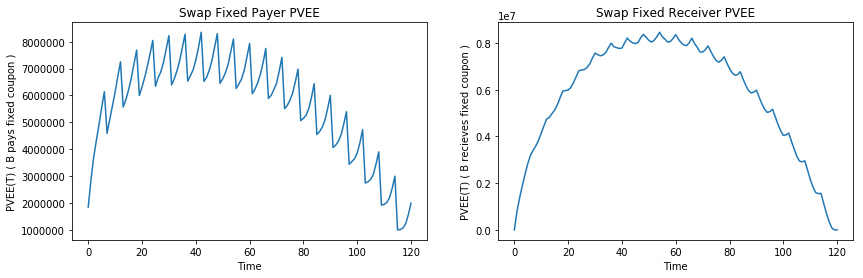

In [95]:
%matplotlib inline
plt.figure(1,figsize=(14,4))
ax_1 = plt.subplot(1,2,1) 
ax_1.set_title("Swap Fixed Payer PVEE")
ax_1.plot(PVEE_B_pay_path_average)
ax_1.set_xlabel('Time')
ax_1.set_ylabel('PVEE(T) ( B pays fixed coupon )')
ax_2 = plt.subplot(1,2,2) 
ax_2.plot(PVEE_B_rec_path_average)
ax_2.set_title('Swap Fixed Receiver PVEE')
ax_2.set_xlabel('Time') 
ax_2.set_ylabel('PVEE(T) ( B recieves fixed coupon )')

In the following part we will consider the credit mitigants in previous section with the collateral agreement and termination agreement in place

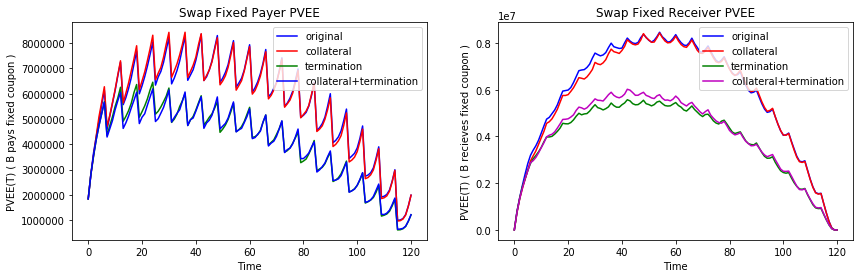

In [127]:
m = 5000
# only with collateral agreement
PVEE_B_pay_path = np.zeros((121,m))
PVEE_B_rec_path = np.zeros((121,m))
E_C_pay_path = [0 for i in range(m)]
E_C_rec_path = [0 for i in range(m)]
P_OIS_path = [0 for i in range(m)]

# only with collateral, then collateral = 1, termination = 0
for n in range(m):
    PVE_C_pay,PVE_C_rec,P_L,E_L,P_OIS_path[n],E_C_pay_path[n],E_C_rec_path[n] = PVEE("C",0.0265,0.02,0.1,1,0)
    PVE_C_rec_1 =  PVE_C_rec.reshape(121)
    PVE_C_pay_1 =  PVE_C_pay.reshape(121)
    PVEE_B_rec_path[:,n] = PVE_C_pay_1
    PVEE_B_pay_path[:,n] = PVE_C_rec_1
    
PVEE_B_rec_path_average_c = []
PVEE_B_pay_path_average_c = []
for i in range(len(PVEE_B_rec_path)):
    PVEE_B_rec_path_average_c.append(notion * PVEE_B_rec_path[i].mean())
for i in range(len(PVEE_B_pay_path)):
    PVEE_B_pay_path_average_c.append(notion * PVEE_B_pay_path[i].mean())

# only with termination, then collateral = 0, termination = 1
for n in range(m):
    PVE_C_pay,PVE_C_rec,P_L,E_L,P_OIS_path[n],E_C_pay_path[n],E_C_rec_path[n] = PVEE("C",0.0265,0.02,0.1,0,1)
    PVE_C_rec_1 =  PVE_C_rec.reshape(121)
    PVE_C_pay_1 =  PVE_C_pay.reshape(121)
    PVEE_B_rec_path[:,n] = PVE_C_pay_1
    PVEE_B_pay_path[:,n] = PVE_C_rec_1
    
PVEE_B_rec_path_average_t = []
PVEE_B_pay_path_average_t = []
for i in range(len(PVEE_B_rec_path)):
    PVEE_B_rec_path_average_t.append(notion * PVEE_B_rec_path[i].mean())
for i in range(len(PVEE_B_pay_path)):
    PVEE_B_pay_path_average_t.append(notion * PVEE_B_pay_path[i].mean())

# with both collateral and temination agreement
for n in range(m):
    PVE_C_pay,PVE_C_rec,P_L,E_L,P_OIS_path[n],E_C_pay_path[n],E_C_rec_path[n] = PVEE("C",0.0265,0.02,0.1,1,1)
    PVE_C_rec_1 =  PVE_C_rec.reshape(121)
    PVE_C_pay_1 =  PVE_C_pay.reshape(121)
    PVEE_B_rec_path[:,n] = PVE_C_pay_1
    PVEE_B_pay_path[:,n] = PVE_C_rec_1
    
PVEE_B_rec_path_average_ct = []
PVEE_B_pay_path_average_ct = []
for i in range(len(PVEE_B_rec_path)):
    PVEE_B_rec_path_average_ct.append(notion * PVEE_B_rec_path[i].mean())
for i in range(len(PVEE_B_pay_path)):
    PVEE_B_pay_path_average_ct.append(notion * PVEE_B_pay_path[i].mean())
    
%matplotlib inline
plt.figure(1,figsize=(14,4))
ax_1 = plt.subplot(1,2,1) 
ax_1.set_title("Swap Fixed Payer PVEE")
ax_1.plot(PVEE_B_pay_path_average,'b',label = 'original')
ax_1.plot(PVEE_B_pay_path_average_c,'r',label = 'collateral')
ax_1.plot(PVEE_B_pay_path_average_t,'g',label = 'termination')
ax_1.plot(PVEE_B_pay_path_average_ct,'b',label = 'collateral+termination')
ax_1.set_xlabel('Time')
ax_1.set_ylabel('PVEE(T) ( B pays fixed coupon )')
ax_1.legend(loc='upper right')
ax_2 = plt.subplot(1,2,2) 
ax_2.plot(PVEE_B_rec_path_average,'b',label = 'original')
ax_2.plot(PVEE_B_rec_path_average_c,'r',label = 'collateral')
ax_2.plot(PVEE_B_rec_path_average_t,'g',label = 'termination')
ax_2.plot(PVEE_B_rec_path_average_ct,'m',label = 'collateral+termination')
ax_2.set_title('Swap Fixed Receiver PVEE')
ax_2.set_xlabel('Time') 
ax_2.set_ylabel('PVEE(T) ( B recieves fixed coupon )')
ax_2.legend(loc='upper right')

## CVA/DVA Calculation

Based on the credit curve setting above, we introduce unilateral and bilateral CVA/DVA in this part. For unilateral CVA/DVA, we only consider risk for banking side. Hence, unilateral CVA only consider one side of default risk(i.e. counterpary(C) default) and unilateral DVA as opposite(i.e. bank(B) default). Pay/Rec is the floating rate side. For example, CVA_B_rec means the CVA for B when B is receiving floating rate.

In [97]:
from numpy.linalg import inv
def XVA(firm,E_X_pay,E_X_rec,P,alpha):
    lam_bda = lambda_func(firm)
    beta_lambda = np.zeros((121,20))
    Q_pay = np.zeros((121,20))
    Q_rec = np.zeros((121,20))
    for n in range(121):
        t = (n+1)/12
        for i in range(20):
            T = (i+1)/2
            if T >= t:
                beta_lambda[n,i] = np.exp(lam_bda[n,i] * (T-t)) 
                Q_rec[n,i] = E_X_pay[n,i] * lam_bda[n,i] * (beta_lambda[n,i] ** (-1)) * P[n,i]
                Q_pay[n,i] = E_X_rec[n,i] * lam_bda[n,i] * (beta_lambda[n,i] ** (-1)) * P[n,i]

    Q_pay_sum = []
    Q_rec_sum = []
    for i in range(len(Q_pay)):
        Q_pay_sum.append(Q_pay[i].sum())
        Q_rec_sum.append(Q_rec[i].sum())


    XVA_pay = (1 - alpha) * np.array(Q_pay_sum) * (1/2)
    XVA_rec = (1 - alpha) * np.array(Q_rec_sum) * (1/2)
    XVA0_pay = XVA_pay.mean()
    XVA0_rec = XVA_rec.mean()
    del lam_bda
    return XVA0_rec,XVA0_pay,XVA_rec,XVA_pay

In [98]:
alpha = 0.4
notion = 150000000
m = 1000
CVA_B_pay_path = np.zeros((121,m))
CVA_B_rec_path = np.zeros((121,m))
CVA0_B_pay_path = np.zeros((1,m))
CVA0_B_rec_path = np.zeros((1,m))

for n in range(m):
    E_C_rec = E_C_rec_path[n]
    E_C_pay = E_C_pay_path[n]
    P = P_OIS_path[n]
    CVA0_B_rec_path[0,n],CVA0_B_pay_path[0,n],CVA_B_rec_path[:,n],CVA_B_pay_path[:,n] = \
    XVA("C",E_C_pay,E_C_rec,P,alpha)

CVA0_B_rec_path_average = notion * CVA0_B_rec_path.mean()
CVA0_B_pay_path_average = notion * CVA0_B_pay_path.mean()

In [99]:
alpha = 0.4
notion = 150000000
m = 1000
DVA_B_pay_path = np.zeros((121,m))
DVA_B_rec_path = np.zeros((121,m))
DVA0_B_pay_path = np.zeros((1,m))
DVA0_B_rec_path = np.zeros((1,m))

for n in range(m):
    E_B_pay = E_C_rec_path[n]
    E_B_rec = E_C_pay_path[n]
    P = P_OIS_path[n]
    DVA0_B_pay_path[0,n],DVA0_B_rec_path[0,n],DVA_B_pay_path[:,n],DVA_B_rec_path[:,n] = XVA("B",E_B_pay,E_B_rec,P,alpha)


DVA0_B_rec_path_average = notion * DVA0_B_rec_path.mean()
DVA0_B_pay_path_average = notion * DVA0_B_pay_path.mean()

In [100]:
print('The CVA (B receiver is) %f' % (CVA0_B_rec_path_average))
print('The CVA (B payer is) %f' % (CVA0_B_pay_path_average))

The CVA (B receiver is) 64443.807483
The CVA (B payer is) 67761.499696


In [101]:
print('The DVA (B receiver is) %f' % (DVA0_B_rec_path_average))
print('The DVA (B payer is) %f' % (DVA0_B_pay_path_average))

The DVA (B receiver is) 23754.919969
The DVA (B payer is) 23483.143191


Here we compute the unilateral net CVA($net\ CVA = CVA - DVA$) 

In [102]:
net_CVA_B_rec = (CVA0_B_rec_path_average - DVA0_B_rec_path_average)
net_CVA_B_pay = (CVA0_B_pay_path_average - DVA0_B_pay_path_average)
print('The net CVA (B receiver is) %f' % net_CVA_B_rec)
print('The net CVA (B payer is) %f' % net_CVA_B_pay)

The net CVA (B receiver is) 40688.887515
The net CVA (B payer is) 44278.356505


For the receiver swap, we graph unilateral CVA/DVA/net CVA against $\sigma_r$ and $\kappa_2$

In [103]:
m = 1000
d = 20
alpha = 0.4
notion = 150000000
# CVA0_B_rec_sigma = np.zeros((d,m))
# DVA0_B_rec_sigma = np.zeros((d,m))
CVA0_B_rec_sigma = np.zeros((m,d))
DVA0_B_rec_sigma = np.zeros((m,d))
# CVA0_B_rec_sigma_average = [0 for _ in range(d)]
# DVA0_B_rec_sigma_average = [0 for _ in range(d)]

for n in range(m):
    for j in range(d):
        sigma_r = ((j+1)/d)
        _,_,_,_,P_OIS_sigma,E_C_pay_sigma,E_C_rec_sigma = PVEE("C",0.0265,sigma_r,0.1,0,0,)
        E_B_pay_sigma = E_C_rec_sigma
        E_B_rec_sigma = E_C_pay_sigma
        CVA0_B_rec_sigma[n,j],_,_,_ = XVA("C",E_C_pay_sigma,E_C_rec_sigma,P_OIS_sigma,alpha)
        _,DVA0_B_rec_sigma[n,j],_,_ = XVA("B",E_B_pay_sigma,E_B_rec_sigma,P_OIS_sigma,alpha)
    
    if (n == 100 or n == 300 or n == 600 or n == 900):
    # for checking the process
        print('------{}------'.format(n))

------100------
------300------
------600------
------900------


In [104]:
#Compute Net CVA = CVA - DVA
Net_uniCVA_B_rec_sigma = notion * (CVA0_B_rec_sigma.mean(0) - DVA0_B_rec_sigma.mean(0))

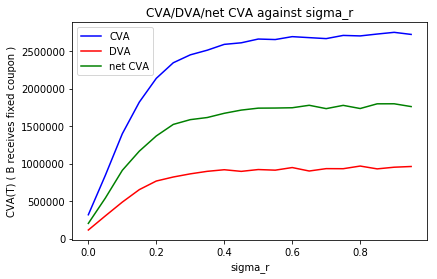

In [105]:
%matplotlib inline
sigma_r = np.arange(0,1,1/20)
plt.figure(1,figsize=(14,4))
ax_1 = plt.subplot(1,2,1) 
ax_1.set_title("CVA/DVA/net CVA against sigma_r")
ax_1.plot(sigma_r, notion * CVA0_B_rec_sigma.mean(0), color = 'blue',label = 'CVA')
ax_1.plot(sigma_r, notion * DVA0_B_rec_sigma.mean(0), color = 'red',label = 'DVA')
ax_1.plot(sigma_r, Net_uniCVA_B_rec_sigma.transpose(), color = 'green',label = 'net CVA')
ax_1.set_xlabel('sigma_r')
ax_1.set_ylabel('CVA(T) ( B receives fixed coupon )')
ax_1.legend(loc='upper left')

When $\sigma_r$ goes up from zero, CVA, DVA and net CVA go up from a low level immediately. After $\sigma_r$ reaches the level of 0.5, CVA, DVA and net CVA converge to a certain high level. $\sigma_r$ represents the total short rate volatility which affects the OIS discounting rate we simulated. As $\sigma_r$ goes up, the volatility of OIS rate and Libor rate increases and therefore, the expected exposure increases. Thus, CVA, DVA and net CVA increase as $\sigma_r$ increases. 

In [106]:
m = 1000
d = 20
alpha = 0.4
notion = 150000000
CVA0_B_rec_k2 = np.zeros((m,d))
DVA0_B_rec_k2 = np.zeros((m,d))
# CVA0_B_rec_k2_average = [0 for _ in range(d)]
# DVA0_B_rec_k2_average = [0 for _ in range(d)]

for n in range(m):
    for j in range(d):
        k2 = ((j+1)/d)
        _,_,_,_,P_OIS_k2,E_C_pay_k2,E_C_rec_k2 = PVEE("C",0.0265,0.02,k2,0,0,)
        E_B_pay_k2 = E_C_rec_k2
        E_B_rec_k2 = E_C_pay_k2
        CVA0_B_rec_k2[n,j],_,_,_ = XVA("C",E_C_pay_k2,E_C_rec_k2,P_OIS_k2,alpha)
        _,DVA0_B_rec_k2[n,j],_,_ = XVA("B",E_B_pay_k2,E_B_rec_k2,P_OIS_k2,alpha)
    
    if (n == 100 or n == 300 or n == 600 or n == 900):
    # for checking the process
        print('------{}------'.format(n))

------100------
------300------
------600------
------900------


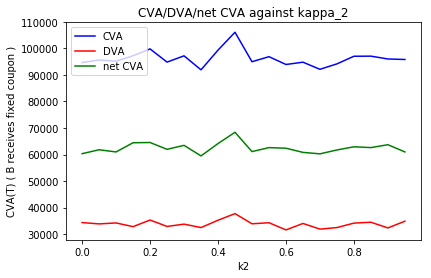

In [107]:
%matplotlib inline
Net_uniCVA_B_rec_k2 = (CVA0_B_rec_k2.mean(0) - DVA0_B_rec_k2.mean(0))
k2 = np.arange(0,1,1/20)
plt.figure(1,figsize=(14,4))
ax_1 = plt.subplot(1,2,1) 
ax_1.set_title("CVA/DVA/net CVA against kappa_2")
ax_1.plot(k2, notion * CVA0_B_rec_k2.mean(0), color = 'blue',label = 'CVA')
ax_1.plot(k2, notion * DVA0_B_rec_k2.mean(0), color = 'red',label = 'DVA')
ax_1.plot(k2, notion * Net_uniCVA_B_rec_k2, color = 'green',label = 'net CVA')
ax_1.set_xlabel('k2')
ax_1.set_ylabel('CVA(T) ( B receives fixed coupon )')
ax_1.legend(loc='upper left')

Theoritically, $\kappa_2$ reflects the long term mean reversion speed. It determines in which way long term volatility decays. As $\kappa_2$ increases, the mean reversion speed of x(t) increases and therefore the volatility of OIS rate decreases. However, we cannot see decay process here probably beacuse of insufficient simulation.

In the previous part, when we compute the CVA from B's perspective, we assumed that B itself could not default. On the other hand, when computing DVA for B, we assumed that C could not default. Obviously, they are both not coherent, as we should incorporate __joint default risk__. For example, We should have equally defined a CVA charge from the perspective of C. This would involve the default intensity $\lambda_B$ of firm B

In [108]:
def biXVA(firm_self,firm_ctp,E_X_pay,E_X_rec,P,alpha):
    lambda_1 = lambda_func(firm_self)
    lambda_2 = lambda_func(firm_ctp)
    beta_lambda = np.zeros((121,20))
    Q_pay = np.zeros((121,20))
    Q_rec = np.zeros((121,20))
    
    for n in range(120):
        t = (n+1)/12
        for i in range(20):
            T = (i+1)/2
            if T >= t:
                beta_lambda[n,i] = np.exp((lambda_1[n,i] + lambda_2[n,i]) * (T-t)) 
                Q_rec[n,i] = E_X_pay[n,i] * lambda_2[n,i] * P[n,i] * (beta_lambda[n,i] ** (-1))
                Q_pay[n,i] = E_X_rec[n,i] * lambda_2[n,i] * P[n,i] * (beta_lambda[n,i] ** (-1))
    
    Q_pay_sum = []
    Q_rec_sum = []
    
    for i in range(len(Q_pay)):
        Q_pay_sum.append(Q_pay[i].sum())
        Q_rec_sum.append(Q_rec[i].sum())

    
    bi_XVA_pay = (1-alpha) * np.array(Q_pay_sum) * (1/2)
    bi_XVA_rec = (1-alpha) * np.array(Q_rec_sum) * (1/2)
  
    
    bi_XVA0_pay = np.mean(bi_XVA_pay)
    bi_XVA0_rec = np.mean(bi_XVA_rec)

    return bi_XVA0_pay, bi_XVA0_rec, bi_XVA_pay, bi_XVA_rec


In [109]:
# compute bilateral CVA
alpha = 0.4
notion = 150000000
m = 1000
bi_CVA_pay_path = np.zeros((121,m))
bi_CVA_rec_path = np.zeros((121,m))
bi_CVA0_pay_path = np.zeros((1,m))
bi_CVA0_rec_path = np.zeros((1,m))

for n in range(m):
    E_C_pay = E_C_pay_path[n]
    E_C_rec = E_C_rec_path[n]
    P = P_OIS_path[n]
    bi_CVA0_pay_path[0,n],bi_CVA0_rec_path[0,n],bi_CVA_pay_path[:,n],bi_CVA_rec_path[:,n] = \
    biXVA("B","C",E_C_pay,E_C_rec,P,alpha)


bi_CVA0_rec_path_average = notion * bi_CVA0_rec_path.mean()
bi_CVA0_pay_path_average = notion * bi_CVA0_pay_path.mean()

In [110]:
print('The bilateral CVA (B receiver is) %f' % (bi_CVA0_rec_path_average))
print('The bilateral CVA (B payer is) %f' % (bi_CVA0_pay_path_average))

The bilateral CVA (B receiver is) 65347.814921
The bilateral CVA (B payer is) 66344.101798


In [111]:
# compute bilateral DVA
alpha = 0.4
notion = 150000000
m = 1000
bi_DVA_pay_path = np.zeros((121,m))
bi_DVA_rec_path = np.zeros((121,m))
bi_DVA0_pay_path = np.zeros((1,m))
bi_DVA0_rec_path = np.zeros((1,m))

for n in range(m):
    E_B_pay = E_C_rec_path[n]
    E_B_rec = E_C_pay_path[n]
    P = P_OIS_path[n]
    bi_DVA0_pay_path[0,n],bi_DVA0_rec_path[0,n],bi_DVA_pay_path[:,n],bi_DVA_rec_path[:,n] = \
    biXVA("C","B",E_B_pay,E_B_rec,P,alpha)


bi_DVA0_rec_path_average = notion * bi_DVA0_rec_path.mean()
bi_DVA0_pay_path_average = notion * bi_DVA0_pay_path.mean()

In [112]:
print('The bilateral DVA (B receiver is) %f' % (bi_DVA0_rec_path_average))
print('The bilateral DVA (B payer is) %f' % (bi_DVA0_pay_path_average))

The bilateral DVA (B receiver is) 22947.267178
The bilateral DVA (B payer is) 22997.265446


## IMM Exercise

---

Assume that historical averages of interest rate and default intensity volatilities are similar to the implied volatilities in previous section. And also assume that IMM simulation aim to distribute intensities and interest rates around their time 0 forward values. We need to set $y(t) = 0$ to insure that $r(t)$ will be centered around $f(0,t)$

Based on the new requirement, to maintian risk neutral assumption we must set y_t = 0. We have to remove drift term when calculating

In [113]:
def OIS_IMM(sigma_r,kappa_1,kappa_2,OIS_0_T):
    corr_matrix = corr_variables(corr_B_L,corr_B_S,corr_C_L,corr_C_S,corr_B_C,corr,c)
    Z = corr_matrix[:,2:4]
    vega = np.sqrt(c ** (-2) - 1 - 2 * (corr/c - 1))
    corr_x = (corr/c - 1)/vega
    sigma_1 = c*sigma_r
    sigma_2 = vega * sigma_1
    sigma_22 = sigma_2
    sigma_21 = corr_x * sigma_1 * sigma_2/sigma_22
    sigma_11 = np.sqrt(sigma_1 ** 2 - sigma_21 ** 2)
    sigma_x = np.matrix([[sigma_1,0],[0,sigma_2]]).transpose()

    #compute X(t)
    X = [np.matrix([[0],[0]]) for _ in range(121)]
    one = np.matrix([[1],[1]])  
    y_t = [np.matrix([[0,0],[0,0]]) for _ in range(121)]

    dt = 1/12
    for n in range(120):
        t = (n+1)/12
        Z_n = Z[n,:].reshape(2,1)
        kappa = np.matrix([[kappa_1,0],[0,kappa_2]]) 
        dx = (y_t[n].dot(one) - kappa.dot(X[n])) * dt + (sigma_x.dot(Z_n*np.sqrt(dt)))
        X[n+1] = X[n] + dx    


    forward_OIS_IMM = np.zeros((120,20))
    for n in range(120):
        t = (n+1)/12
        for i in range(20):
            T = (i+1)/2
            if T >= t:
                M = np.matrix([np.exp(-kappa_1 * (T - t)),np.exp(-kappa_2 * (T - t))]) 
                G = np.matrix([1/kappa_1 * (1 - M.item(0,0)),1/kappa_2 * (1- M.item(0,1))])            
                forward_OIS_IMM[n,i] = OIS_0_T + M.dot((X[n+1] + y_t[n+1].dot(G.transpose())))
    
    return forward_OIS_IMM

In [114]:
def EE_IMM(coupon, sigma_r, k2):
    
    dt = 1/12
    T = 10
    forward_OIS = OIS_IMM(sigma_r,kappa_1,kappa_2,OIS_0_T)
    #Compute P_OIS
    P_OIS = np.ones((121,20))

    for i in range(20):
        T = (i+1)/2
        P_OIS[0,:] = np.exp(-OIS_0_T * T)
    for n in range(120):
        t = (n+1)/12
        for i in range(20):
            T = (i+1)/2
            if T >= t:
                P_OIS[n+1,i] = np.exp(-forward_OIS[n,i] * (T-t)) 

    P_L = np.ones((121,20))
    for n in range(121):
        t = n/12
        for i in range(20):
            T = (i+1)/2
            if T>=t:
                P_L[n,i] = P_OIS[n,i] * np.exp(-0.005 * (T-t))

    E_L = np.zeros((121,20))
    E_L[0,:] = 0.025
    L = np.zeros((1,20))
    L[0,0] = 0.025
    for i in range(19):
        L[0,i+1] = (P_L[6*(i+1),(i+1)] ** (-1) -1)/dt


    #we add one more column of L_0 into P_L
    P_L_temp = np.ones((121,21))
    P_L_temp[0,0] = P_L[0,0]
    P_L_temp[:,1:] = P_L

    for n in range(1,121):
        t = n/12
        for i in range(20):
            T = (i+1)/2
            if t <= T:
                E_L[n,i] = (P_L_temp[n,i]/P_L_temp[n,i+1]-1)/(1/2)
            else:
                E_L[n,i] = L[0,i]

    PVE_C_pay = np.zeros((121,1))
    exposure_pay = np.zeros((121,20))
    # calculate PVEE for fixed payer PV_0,PV_1,.....,PV_120
    # assume LIBOR is exchanged against a coupon of 2.65%
    for n in range(121):
        t = n/12
        for i in range(20):
            T = (i+1)/2
            exposure_pay[n,i] = max(E_L[n,i] - 0.0265,0)
            if T >= t:
                temp = P_OIS[n,i] * (1/2) * exposure_pay[n,i]
                PVE_C_pay[n,0] = PVE_C_pay[n,0] + temp

    # calculate PVEE for floating receiver PV_0,PV_1,.....,PV_120
    PVE_C_rec = np.zeros((121,1))
    exposure_rec = np.zeros((121,20))

    for n in range(121):
        t = n/12
        for i in range(20):
            T = (i+1)/2
            exposure_rec[n,i] = max(-E_L[n,i]+0.0265,0)
            if T >= t:
                temp = P_OIS[n,i] * (1/2) * exposure_rec[n,i]
                PVE_C_rec[n,0] = PVE_C_rec[n,0] + temp
    
    return PVE_C_pay,PVE_C_rec,P_L,E_L,P_OIS,exposure_pay,exposure_rec

In [115]:
notion = 150000000
m = 5000
EE_B_pay_path = np.zeros((121,m))
EE_B_rec_path = np.zeros((121,m))
E_C_pay_path = [0 for i in range(m)]
E_C_rec_path = [0 for i in range(m)]
P_OIS_path = [0 for i in range(m)]

for n in range(m):
    PVE_C_pay,PVE_C_rec,P_L,E_L,P_OIS_path[n],E_C_pay_path[n],E_C_rec_path[n] = EE_IMM(0.0265,0.02,0.1)
    PVE_C_rec_1 =  PVE_C_rec.reshape(121)
    PVE_C_pay_1 =  PVE_C_pay.reshape(121)
    EE_B_rec_path[:,n] = PVE_C_pay_1
    EE_B_pay_path[:,n] = PVE_C_rec_1
    
EE_B_rec_path_average = []
EE_B_pay_path_average = []
for i in range(len(EE_B_rec_path)):
    EE_B_rec_path_average.append(notion * EE_B_rec_path[i].mean())
for i in range(len(EE_B_pay_path)):
    EE_B_pay_path_average.append(notion * EE_B_pay_path[i].mean())

Text(0,0.5,'EE(T) ( B recieves fixed coupon )')

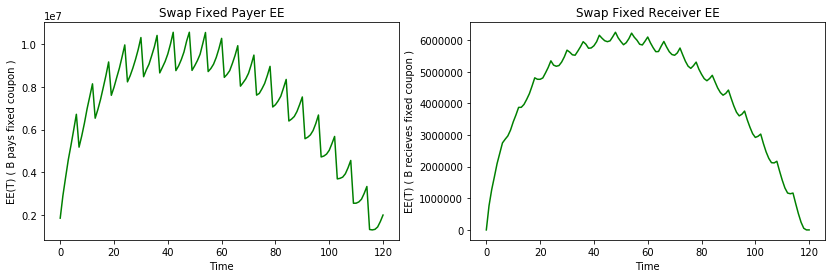

In [116]:
%matplotlib inline
plt.figure(1,figsize=(14,4))
ax_1 = plt.subplot(1,2,1) 
ax_1.set_title("Swap Fixed Payer EE")
ax_1.plot(EE_B_pay_path_average,'g')
ax_1.set_xlabel('Time')
ax_1.set_ylabel('EE(T) ( B pays fixed coupon )')
ax_2 = plt.subplot(1,2,2) 
ax_2.plot(EE_B_rec_path_average,'g')
ax_2.set_title('Swap Fixed Receiver EE')
ax_2.set_xlabel('Time') 
ax_2.set_ylabel('EE(T) ( B recieves fixed coupon )')

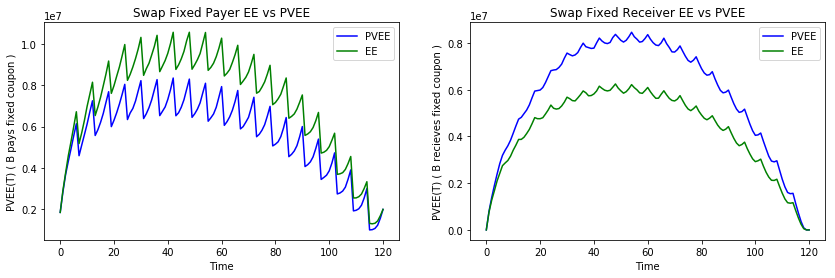

In [117]:
#compare EE with PVEE
%matplotlib inline
plt.figure(1,figsize=(14,4))
ax_1 = plt.subplot(1,2,1) 
ax_1.set_title("Swap Fixed Payer EE vs PVEE")
ax_1.plot(PVEE_B_pay_path_average,'b',label = 'PVEE')
ax_1.plot(EE_B_pay_path_average,'g',label = 'EE')
ax_1.set_xlabel('Time')
ax_1.set_ylabel('PVEE(T) ( B pays fixed coupon )')
ax_1.legend(loc = 'upper right')
ax_2 = plt.subplot(1,2,2) 
ax_2.plot(PVEE_B_rec_path_average,'b',label = 'PVEE')
ax_2.plot(EE_B_rec_path_average,'g',label = 'EE')
ax_2.set_title('Swap Fixed Receiver EE vs PVEE')
ax_2.set_xlabel('Time') 
ax_2.set_ylabel('PVEE(T) ( B recieves fixed coupon )')
ax_2.legend(loc = 'upper right')

The purpose of IMM is to find a way to take an arbitrary dervatives portfolio(including its collateral) and replace it with a "representative" loan notional<br>
<br>
Expected Exposure profile is the time-average of the exposure curve. Typically we primarily focus on those curve who have default event which is $Pr(\tau \in dt\ |\ \tau \le T)$,<br><br>
$E(E(\tau)\ |\ \tau \le T) \approx \frac{1}{T}\int_{0}^{T} EE(t) dt = EPE(T)$

Basel mandates for regulatory capital computations one does not use the EE profile directly, but instead an alternative profile EE* (effective EE) that is found as a funning maximum of the EE profile: <br>
<br>
$\ EE^*(t_i) = max(EE^*(t_{i-1},EE(t_i))$ <br> 
<br>
Then the time-average of EE* is called EEPE: <br>
<br>
$EEPE(T) = \frac{1}{T}\int_{0}^{T} EE^*(t) dt$ <br>
<br>

In Basel III, Effective Expected Positive Exposure (EEPE), Exposure at Default(EAD) is defined as follow, 

In [118]:
def EEPE(EE_IMM_pay, EE_IMM_rec):
    EE_star_B_pay = np.zeros((121,1))
    EE_star_B_pay[0] = EE_IMM_pay[0]
    EE_star_B_rec = np.zeros((121,1))
    EE_star_B_rec[0] = EE_IMM_rec[0]
    
    for n in range(1,121):
        EE_star_B_pay[n] = max(EE_star_B_pay[n-1],EE_IMM_pay[n])
        EE_star_B_rec[n] = max(EE_star_B_rec[n-1],EE_IMM_rec[n])
    
    T = 1
    n = 1/12
    EEPE_B_pay = sum(EE_star_B_pay[:(int(T/n)+1)])/(n+1)
    EEPE_B_rec = sum(EE_star_B_rec[:(int(T/n)+1)])/(n+1)
    return EE_star_B_pay, EE_star_B_rec, EEPE_B_pay, EEPE_B_rec

In [119]:
EE_star_B_pay, EE_star_B_rec, EEPE_B_pay, EEPE_B_rec = EEPE(EE_B_pay_path_average,EE_B_rec_path_average)
print('EEPE (B as payer) is %f' % EEPE_B_pay)
print('EEPE (B as receiver) is %f' % EEPE_B_rec)

EEPE (B as payer) is 68198453.036848
EEPE (B as receiver) is 28513481.411692


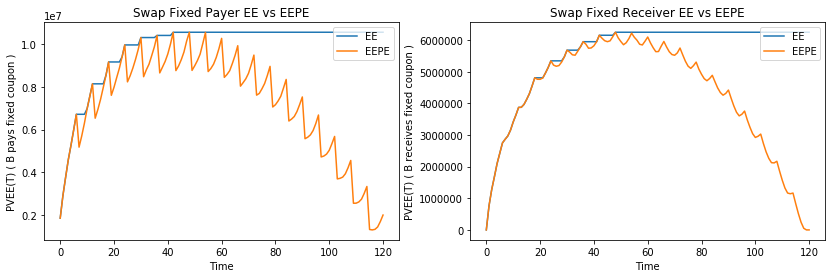

In [120]:
#compare EE with EEPE
%matplotlib inline
plt.figure(1,figsize=(14,4))
ax_1 = plt.subplot(1,2,1) 
ax_1.set_title("Swap Fixed Payer EE vs EEPE")
ax_1.plot(EE_star_B_pay,label = 'EE')
ax_1.plot(EE_B_pay_path_average,label = 'EEPE')
ax_1.set_xlabel('Time')
ax_1.set_ylabel('PVEE(T) ( B pays fixed coupon )')
ax_1.legend(loc = 'upper right')
ax_2 = plt.subplot(1,2,2) 
ax_2.plot(EE_star_B_rec,label = 'EE')
ax_2.plot(EE_B_rec_path_average,label = 'EEPE')
ax_2.set_title('Swap Fixed Receiver EE vs EEPE')
ax_2.set_xlabel('Time') 
ax_2.set_ylabel('PVEE(T) ( B receives fixed coupon )')
ax_2.legend(loc = 'upper right')

Basel committee proposed to introduce a scale $\alpha > 1$. The $\alpha$ multiplier is meant to adjust for a variety of effects: wrong-way risk, variance of the exposure, finite granularity of portfolios, noise in E(t) simulation etc. __Basel 2 uses $\alpha = 1.4$__. Also BCBS has introduced another factor which is to maintain the aggregate level of risk capital requirement. Hence they have applied a new scaling factor under IRB approach. The current best estimate of the scaling factor using quantitative impact study(QIS) data is 1.06<br>
<br>
In reality the counterparty can default so portfolio value needs to be adjusted down by CVA. So in Basel 3, The final EAD is equal to<br>
<br>
$EAD\ =\ 1.06*max(\alpha EEPE(T) - CVA,0)$


In [121]:
def EAD(EEPE_B_pay, EEPE_B_rec, CVA_B_pay, CVA_B_rec):
    alpha = 1.4
    EAD_pay = 1.06 * max([alpha*EEPE_B_pay - CVA_B_pay,0])
    EAD_rec = 1.06 * max([alpha*EEPE_B_rec - CVA_B_rec,0])
    return EAD_pay, EAD_rec

In [122]:
EAD_pay, EAD_rec = EAD(EEPE_B_pay, EEPE_B_rec, CVA0_B_pay_path_average, CVA0_B_rec_path_average)
print('EAD (B as payer) is %f' % EAD_pay)
print('EAD (B as reveiver) is %f' % EAD_rec)

EAD (B as payer) is 101134677.117005
EAD (B as reveiver) is 42245695.979019


IMM also covers the computation of effective maturity __M__, which represents credit spread duration

In [123]:
def M_IMM(EE_star,EE,N):
    EE_star_t = []
    EE_t = []
    EE_star_t = EE_star_B_rec[:12]/(1/12) 
    EE_t = [EE_B_rec_path_average[i]/(1/12) for i in range(len(EE_B_rec_path_average))]
    EE_star_t_new = []
    EE_t_new = []
    for EE in EE_star_t:
        EE_star_t_new.append(EE[0]*dt)
    for EE in EE_t:
        EE_t_new.append(EE*dt)
    EEstarint = sum(EE_star_t_new)
    EEint = sum(EE_t_new)
    M = EEint/EEstarint
    return M


In [124]:
M_rec = M_IMM(EE_star_B_rec, EE_B_rec_path_average,1/12)
M_pay = M_IMM(EE_star_B_pay, EE_B_pay_path_average,1/12)

Basel 2 uses following Internal Ratings-Based(IRB) formula for credit risk regulatory capital<br>
$RC = EAD\cdot RW$<br>
$EAD = 1.06*max(\alpha \cdot EEPE(1)-CVA,0)$<br>
$RW = LGD\cdot ( \phi (\frac{\phi^{-1}(p)-\sqrt{\rho(p)}\phi^{-1}(0.001)}{\sqrt{1-\rho(p)}})-p) \cdot k(M,p)$
<br>
<br>
Now, lets suppose that p = 1-year probability of default(PD) = 1%, 

In [125]:
from scipy.stats import norm
import math
def RegCap(EAD,PD,LGD,M):
    rho = 0.24 - 0.12*(1 - math.exp(-50 * PD))
    b_y=(0.11852-0.05478 * math.log(PD)) ** 2
    k_M_p=(1+(M-2.5)*b_y)/(1-1.5*b_y)
    RW = LGD*((norm.cdf(PD) - math.sqrt(rho) * norm.cdf(0.001))/(math.sqrt(1-rho) - PD)) * k_M_p
    RC = EAD * RW
    return RC

In [126]:
PD= 0.01
LGD= 1 - 0.4
RC_B_rec = RegCap(EAD_rec,PD,LGD,M_rec)
RC_B_pay = RegCap(EAD_pay,PD,LGD,M_pay)

print('Regulatory Capital (B as receiver) is %f' % RC_B_rec)
print('Regulatory Capital (B as payer) is %f' % RC_B_pay)

Regulatory Capital (B as receiver) is 33582431.262295
Regulatory Capital (B as payer) is 80395132.895977


## Reference

[1]Anderson, L.(2014), "Background Material: Cox Default Processes, CVA, and Expected Exposure", Lecture Notes.<br>
[2]Anderson, L.(2014), "Background Material: Gaussian and Quasi-Gaussian Models", Lecture Notes.<br>
[2]Anderson, L.(2017), "Regulation, Capital, and Margining: Quant Angle", Lecture Notes.<br>